In [1]:
import os
import numpy as np
from astropy.io import fits, ascii
from astropy.table import Table
from matplotlib import pyplot as plt

In [2]:
# Path to data (OI FITS file)
path_load = f"../../data/HD_100453/GRAVITY/SCI_HD100453_GRAVITY_MED_singlescivis_0000_singlesciviscalibrated_0000.fits"

In [3]:
# ---- interferometric parameters
n_baselines = 6
n_triplets = 4

# ---- exposure time bins [h]
exptime_bin = 0.5

# ---- spectral binning of SC data
spectral_bins = 5

lambda_min = 2.03e-6

# minimum errors of visibilities and CPs
e_min_vis2 = 0.02
e_min_cp = 1.

In [4]:
# load file
hdu = fits.open(os.path.join(path_load))

In [5]:
# get target name
target = hdu[0].header['HIERARCH ESO FT ROBJ NAME']

# get number of exposures and corresponding uv_bins
n_exp = int(len(hdu[10].data['UCOORD']) / n_baselines)

# get duration of the observation
obs_time = (np.max(hdu[10].data['MJD']) - np.min(hdu[10].data['MJD'])) * 24
print(f'Total integration time: {obs_time} h')

Total integration time: 0.20083333365619183 h


In [6]:
# bin down to 1 data point per half hour of observation
if obs_time / exptime_bin < 1:
    n_bin_exp = n_exp
else:
    n_bin_exp = int(np.ceil(n_exp / (obs_time / exptime_bin)))
print(f'Number of binned exposures: {n_bin_exp}')

Number of binned exposures: 2


In [7]:
# get number of UV bins
n_uv_bins = int(np.ceil(n_exp / n_bin_exp))

# UT names and indices
index_to_ut = dict.fromkeys(hdu[1].data['STA_INDEX'])
for l, tmp_index in enumerate(hdu[1].data['STA_INDEX']):
    index_to_ut[tmp_index] = hdu[1].data['STA_NAME'][l]

In [8]:
# get u and v coordinates for FT
u_coord_ft = hdu[6].data['UCOORD']
v_coord_ft = hdu[6].data['VCOORD']
baselines_ft = hdu[6].data['STA_INDEX']
u1_coord_ft = hdu[7].data['U1COORD']
v1_coord_ft = hdu[7].data['V1COORD']
u2_coord_ft = hdu[7].data['U2COORD']
v2_coord_ft = hdu[7].data['V2COORD']
u3_coord_ft = - (u1_coord_ft + u2_coord_ft)
v3_coord_ft = - (v1_coord_ft + v2_coord_ft)
triplets_ft = hdu[7].data['STA_INDEX']

In [9]:
# get FT wavelengths
wavelengths_ft = hdu[4].data['EFF_WAVE']

# get FT visibilities
vis2_ft_flag = np.invert(hdu[6].data['FLAG'])
vis2_ft = hdu[6].data['VIS2DATA']
e_vis2_ft = hdu[6].data['VIS2ERR']

# get FT closure phases
cp_ft_flag = np.invert(hdu[7].data['FLAG'])
cp_ft = hdu[7].data['T3PHI']
e_cp_ft = hdu[7].data['T3PHIERR']

In [10]:
# get u and v coordinates for SC
u_coord_sc = hdu[10].data['UCOORD']
v_coord_sc = hdu[10].data['VCOORD']
baselines_sc = hdu[10].data['STA_INDEX']
u1_coord_sc = hdu[11].data['U1COORD']
v1_coord_sc = hdu[11].data['V1COORD']
u2_coord_sc = hdu[11].data['U2COORD']
v2_coord_sc = hdu[11].data['V2COORD']
u3_coord_sc = - (u1_coord_sc + u2_coord_sc)
v3_coord_sc = - (v1_coord_sc + v2_coord_sc)
triplets_sc = hdu[11].data['STA_INDEX']

In [11]:
# get SC wavelengths
wavelengths_sc = hdu[3].data['EFF_WAVE']

# get SC visibilities
vis2_sc_flag = np.invert(hdu[10].data['FLAG'])
vis2_sc = hdu[10].data['VIS2DATA']
e_vis2_sc = hdu[10].data['VIS2ERR']

# set VIS2 flag to false for obviously wrong values
vis2_sc_flag[vis2_sc <= 1e-10] = False
vis2_sc_flag[e_vis2_sc <= 1e-10] = False

# get SC closure phases
cp_sc_flag = np.invert(hdu[11].data['FLAG'])
cp_sc = hdu[11].data['T3PHI']
e_cp_sc = hdu[11].data['T3PHIERR']

# set CP flag to false for obviously wrong values
cp_sc_flag[np.abs(cp_sc) <= 1e-10] = False
cp_sc_flag[np.abs(e_cp_sc) <= 1e-10] = False

# get flags for coordinates
vis2_coord_sc_flag = np.max(vis2_sc_flag, axis=1)
cp_coord_sc_flag = np.max(cp_sc_flag, axis=1)

In [12]:
# ---- average exposures of SC data
if n_bin_exp == 1:
    # --- VIS2
    vis2_sc_avg_exp = vis2_sc.copy()
    e_vis2_sc_avg_exp = e_vis2_sc.copy()
    vis2_sc_flag_avg_exp = vis2_sc_flag.copy()
    u_coord_sc_avg_exp = u_coord_sc.copy()
    v_coord_sc_avg_exp = v_coord_sc.copy()
    vis2_coord_sc_flag_avg_exp = vis2_coord_sc_flag.copy()

    # --- CPs
    cp_sc_avg_exp = cp_sc.copy()
    e_cp_sc_avg_exp = e_cp_sc.copy()
    cp_sc_flag_avg_exp = cp_sc_flag.copy()
    u1_coord_sc_avg_exp = u1_coord_sc.copy()
    v1_coord_sc_avg_exp = v1_coord_sc.copy()
    u2_coord_sc_avg_exp = u2_coord_sc.copy()
    v2_coord_sc_avg_exp = v2_coord_sc.copy()
    u3_coord_sc_avg_exp = u3_coord_sc.copy()
    v3_coord_sc_avg_exp = v3_coord_sc.copy()
    cp_coord_sc_flag_avg_exp = cp_coord_sc_flag.copy()
else:
    # --- VIS2
    vis2_sc_avg_exp = np.zeros((n_baselines * n_uv_bins, len(wavelengths_sc)))
    e_vis2_sc_avg_exp = np.zeros((n_baselines * n_uv_bins, len(wavelengths_sc)))
    vis2_sc_flag_avg_exp = np.zeros((n_baselines * n_uv_bins, len(wavelengths_sc)), dtype=bool)
    u_coord_sc_avg_exp = np.zeros((n_baselines * n_uv_bins))
    v_coord_sc_avg_exp = np.zeros((n_baselines * n_uv_bins))
    vis2_coord_sc_flag_avg_exp = np.zeros((n_baselines * n_uv_bins), dtype=bool)

    for m in range(n_uv_bins):
        for l in range(n_baselines):
            tmp_vis2_sc = vis2_sc.copy()
            tmp_e_vis2_sc = e_vis2_sc.copy()
            tmp_u_coord_sc = u_coord_sc.copy()
            tmp_v_coord_sc = v_coord_sc.copy()

            tmp_vis2_sc[np.invert(vis2_sc_flag)] = np.nan
            tmp_e_vis2_sc[np.invert(vis2_sc_flag)] = np.nan
            tmp_u_coord_sc[np.invert(vis2_coord_sc_flag)] = np.nan
            tmp_v_coord_sc[np.invert(vis2_coord_sc_flag)] = np.nan

            tmp_weights_avg_exp = (1 / (tmp_e_vis2_sc[l + n_baselines * m * n_bin_exp:l + n_baselines * (m + 1) * n_bin_exp:n_baselines, :])) ** 2

            tmp_vis2_avg_exp = np.nansum(tmp_weights_avg_exp * tmp_vis2_sc[l + n_baselines * m * n_bin_exp:l + n_baselines * (m + 1) * n_bin_exp:n_baselines], axis=0) / np.nansum(tmp_weights_avg_exp, axis=0)
            tmp_e_vis2_avg_exp = np.sqrt((np.nansum(tmp_weights_avg_exp * tmp_vis2_sc[l + n_baselines * m * n_bin_exp:l + n_baselines * (m + 1) * n_bin_exp:n_baselines] ** 2, axis=0) /
                                          np.nansum(tmp_weights_avg_exp, axis=0) - (tmp_vis2_avg_exp) ** 2) / np.array([len(tmp_w[np.invert(np.isnan(tmp_w))]) - 1 for tmp_w in tmp_weights_avg_exp.T[:, ]]))

            vis2_sc_avg_exp[l + n_baselines * m,] = tmp_vis2_avg_exp
            e_vis2_sc_avg_exp[l + n_baselines * m,] = tmp_e_vis2_avg_exp
            vis2_sc_flag_avg_exp[l + n_baselines * m,] = np.invert(np.isinf(tmp_e_vis2_avg_exp)) & np.invert(np.isnan(tmp_e_vis2_avg_exp)) & np.max(vis2_sc_flag[l + n_baselines * m * n_bin_exp:l + n_baselines * (m + 1) * n_bin_exp:n_baselines,], axis=0)

            u_coord_sc_avg_exp[l + n_baselines * m] = np.nanmean(tmp_u_coord_sc[l + n_baselines * m * n_bin_exp:l + n_baselines * (m + 1) * n_bin_exp:n_baselines])
            v_coord_sc_avg_exp[l + n_baselines * m] = np.nanmean(tmp_v_coord_sc[l + n_baselines * m * n_bin_exp:l + n_baselines * (m + 1) * n_bin_exp:n_baselines])
            vis2_coord_sc_flag_avg_exp[l + n_baselines * m] = np.max(vis2_coord_sc_flag[l + n_baselines * m * n_bin_exp:l + n_baselines * (m + 1) * n_bin_exp:n_baselines])

    # --- CPs
    cp_sc_avg_exp = np.zeros((n_triplets * n_uv_bins, len(wavelengths_sc)))
    e_cp_sc_avg_exp = np.zeros((n_triplets * n_uv_bins, len(wavelengths_sc)))
    cp_sc_flag_avg_exp = np.zeros((n_triplets * n_uv_bins, len(wavelengths_sc)), dtype=bool)
    u1_coord_sc_avg_exp = np.zeros((n_triplets * n_uv_bins))
    v1_coord_sc_avg_exp = np.zeros((n_triplets * n_uv_bins))
    u2_coord_sc_avg_exp = np.zeros((n_triplets * n_uv_bins))
    v2_coord_sc_avg_exp = np.zeros((n_triplets * n_uv_bins))
    u3_coord_sc_avg_exp = np.zeros((n_triplets * n_uv_bins))
    v3_coord_sc_avg_exp = np.zeros((n_triplets * n_uv_bins))
    cp_coord_sc_flag_avg_exp = np.zeros((n_triplets * n_uv_bins), dtype=bool)

    for m in range(n_uv_bins):
        for l in range(n_triplets):
            tmp_cp_sc = cp_sc.copy()
            tmp_e_cp_sc = e_cp_sc.copy()
            tmp_u1_coord_sc = u1_coord_sc.copy()
            tmp_u2_coord_sc = u2_coord_sc.copy()
            tmp_u3_coord_sc = u3_coord_sc.copy()
            tmp_v1_coord_sc = v1_coord_sc.copy()
            tmp_v2_coord_sc = v2_coord_sc.copy()
            tmp_v3_coord_sc = v3_coord_sc.copy()

            tmp_cp_sc[np.invert(cp_sc_flag)] = np.nan
            tmp_e_cp_sc[np.invert(cp_sc_flag)] = np.nan
            tmp_u1_coord_sc[np.invert(cp_coord_sc_flag)] = np.nan
            tmp_u2_coord_sc[np.invert(cp_coord_sc_flag)] = np.nan
            tmp_u3_coord_sc[np.invert(cp_coord_sc_flag)] = np.nan
            tmp_v1_coord_sc[np.invert(cp_coord_sc_flag)] = np.nan
            tmp_v2_coord_sc[np.invert(cp_coord_sc_flag)] = np.nan
            tmp_v3_coord_sc[np.invert(cp_coord_sc_flag)] = np.nan

            tmp_weights_avg_exp = (1 / (tmp_e_cp_sc[l + n_triplets * m * n_bin_exp:l + n_triplets * (m + 1) * n_bin_exp:n_triplets, :])) ** 2

            tmp_cp_avg_exp = np.nansum(tmp_weights_avg_exp * tmp_cp_sc[l + n_triplets * m * n_bin_exp:l + n_triplets * (m + 1) * n_bin_exp:n_triplets, :], axis=0) / np.nansum(tmp_weights_avg_exp, axis=0)
            tmp_e_cp_avg_exp = np.sqrt((np.nansum(tmp_weights_avg_exp * tmp_cp_sc[l + n_triplets * m * n_bin_exp:l + n_triplets * (m + 1) * n_bin_exp:n_triplets, :] ** 2, axis=0) /
                                        np.nansum(tmp_weights_avg_exp, axis=0) - (tmp_cp_avg_exp) ** 2) / np.array([len(tmp_w[np.invert(np.isnan(tmp_w))]) - 1 for tmp_w in tmp_weights_avg_exp.T[:, ]]))

            cp_sc_avg_exp[l + n_triplets * m,] = tmp_cp_avg_exp
            e_cp_sc_avg_exp[l + n_triplets * m,] = tmp_e_cp_avg_exp
            cp_sc_flag_avg_exp[l + n_triplets * m,] = np.invert(np.isinf(tmp_e_cp_avg_exp)) & np.invert(np.isnan(tmp_e_cp_avg_exp)) & np.max(cp_sc_flag[l + n_triplets * m * n_bin_exp:l + n_triplets * (m + 1) * n_bin_exp:n_triplets,], axis=0)

            u1_coord_sc_avg_exp[l + n_triplets * m] = np.nanmean(tmp_u1_coord_sc[l + n_triplets * m * n_bin_exp:l + n_triplets * (m + 1) * n_bin_exp:n_triplets])
            v1_coord_sc_avg_exp[l + n_triplets * m] = np.nanmean(tmp_v1_coord_sc[l + n_triplets * m * n_bin_exp:l + n_triplets * (m + 1) * n_bin_exp:n_triplets])
            u2_coord_sc_avg_exp[l + n_triplets * m] = np.nanmean(tmp_u2_coord_sc[l + n_triplets * m * n_bin_exp:l + n_triplets * (m + 1) * n_bin_exp:n_triplets])
            v2_coord_sc_avg_exp[l + n_triplets * m] = np.nanmean(tmp_v2_coord_sc[l + n_triplets * m * n_bin_exp:l + n_triplets * (m + 1) * n_bin_exp:n_triplets])
            u3_coord_sc_avg_exp[l + n_triplets * m] = np.nanmean(tmp_u3_coord_sc[l + n_triplets * m * n_bin_exp:l + n_triplets * (m + 1) * n_bin_exp:n_triplets])
            v3_coord_sc_avg_exp[l + n_triplets * m] = np.nanmean(tmp_v3_coord_sc[l + n_triplets * m * n_bin_exp:l + n_triplets * (m + 1) * n_bin_exp:n_triplets])
            cp_coord_sc_flag_avg_exp[l + n_triplets * m] = np.max(cp_coord_sc_flag[l + n_triplets * m * n_bin_exp:l + n_triplets * (m + 1) * n_bin_exp:n_triplets])

/Users/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/Users/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
/Users/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide


In [13]:
# enhance uncertainties if they are too low
e_vis2_sc_avg_exp[e_vis2_sc_avg_exp<e_min_vis2] = e_min_vis2
e_cp_sc_avg_exp[e_cp_sc_avg_exp<e_min_cp] = e_min_cp

In [14]:
# ---- bin SC data
bin_edges = np.histogram_bin_edges(wavelengths_sc, bins=spectral_bins)

# --- VIS2
wavelengths_sc_vis2_bin = np.zeros((n_baselines * n_uv_bins, spectral_bins))
vis2_sc_bin = np.zeros((n_baselines * n_uv_bins, spectral_bins))
e_vis2_sc_bin = np.zeros((n_baselines * n_uv_bins, spectral_bins))
mask_vis2_sc_bin = np.ones((n_baselines * n_uv_bins, spectral_bins), dtype=bool)

# average to *spectral_bins* wavelength channels
for l, _ in enumerate(vis2_coord_sc_flag_avg_exp):

    for m in range(spectral_bins):
        # mask for current wavelength bin and minimum metrology laser wavelength
        tmp_mask = (wavelengths_sc > bin_edges[m]) & (wavelengths_sc <= bin_edges[m + 1]) & (
                    wavelengths_sc > lambda_min)

        tmp_wavelengths = wavelengths_sc[tmp_mask & vis2_sc_flag_avg_exp[l, :]]
        if len(tmp_wavelengths) < 2:
            mask_vis2_sc_bin[l, m] = False
            continue
        tmp_lam_mean = np.average(tmp_wavelengths)
        tmp_weights = (1 / (e_vis2_sc_avg_exp[l, :])[tmp_mask & vis2_sc_flag_avg_exp[l, :]]) ** 2

        tmp_vis2_mean = np.nansum(tmp_weights * (vis2_sc_avg_exp[l, :])[tmp_mask & vis2_sc_flag_avg_exp[l, :]]) / \
                        np.nansum(tmp_weights)

        tmp_e_vis2_mean = np.sqrt((np.nansum(tmp_weights * (vis2_sc_avg_exp[l, :])[tmp_mask & vis2_sc_flag_avg_exp[l, :]] ** 2) /
                                   np.nansum(tmp_weights) - (tmp_vis2_mean) ** 2) / (len(tmp_weights) - 1))

        wavelengths_sc_vis2_bin[l, m] = tmp_lam_mean
        vis2_sc_bin[l, m] = tmp_vis2_mean
        e_vis2_sc_bin[l, m] = tmp_e_vis2_mean

# --- CPs
wavelengths_sc_cp_bin = np.zeros((n_triplets * n_uv_bins, spectral_bins))
cp_sc_bin = np.zeros((n_triplets * n_uv_bins, spectral_bins))
e_cp_sc_bin = np.zeros((n_triplets * n_uv_bins, spectral_bins))
mask_cp_sc_bin = np.ones((n_triplets * n_uv_bins, spectral_bins), dtype=bool)

for l, _ in enumerate(cp_coord_sc_flag_avg_exp):

    for m in range(spectral_bins):
        # mask for current wavelength bin
        tmp_mask = (wavelengths_sc > bin_edges[m]) & (wavelengths_sc <= bin_edges[m + 1]) & (
                    wavelengths_sc > lambda_min)

        tmp_wavelengths = wavelengths_sc[tmp_mask & cp_sc_flag_avg_exp[l, :]]
        if len(tmp_wavelengths) < 2:
            mask_cp_sc_bin[l, m] = False
            continue
        tmp_lam_mean = np.average(tmp_wavelengths)
        tmp_weights = (1 / (e_cp_sc_avg_exp[l, :])[tmp_mask & cp_sc_flag_avg_exp[l, :]]) ** 2

        tmp_cp_mean = np.nansum(tmp_weights * (cp_sc_avg_exp[l, :])[tmp_mask & cp_sc_flag_avg_exp[l, :]]) / \
                      np.nansum(tmp_weights)
        tmp_e_cp_mean = np.sqrt((np.nansum(tmp_weights * (cp_sc_avg_exp[l, :])[tmp_mask & cp_sc_flag_avg_exp[l, :]] ** 2) /
                                 np.nansum(tmp_weights) - (tmp_cp_mean) ** 2) / (len(tmp_weights) - 1))

        wavelengths_sc_cp_bin[l, m] = tmp_lam_mean
        cp_sc_bin[l, m] = tmp_cp_mean
        e_cp_sc_bin[l, m] = tmp_e_cp_mean

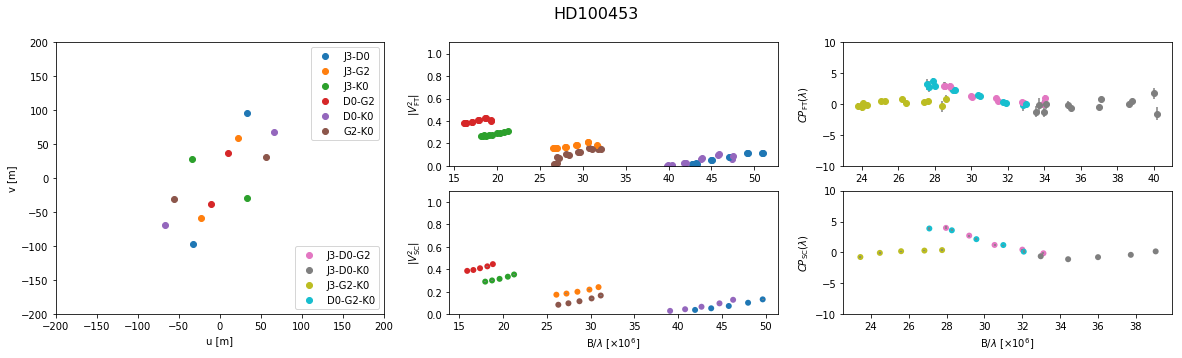

In [15]:
# --- create axes fot the plot
f = plt.figure(figsize=(20,5))

ax_1 = plt.subplot(131)
ax_2 = plt.subplot(232)
ax_3 = plt.subplot(233)
ax_4 = plt.subplot(235)
ax_5 = plt.subplot(236)

# --- plot UV coverage
for j in range(len(u_coord_sc_avg_exp)):

    if not vis2_coord_sc_flag_avg_exp[j]:
        continue

    # fake plot for triplet labels
    if j < n_triplets:
        ax_1.plot(1000,
                  1000,
                  'o',
                  color=f'C{j+n_baselines}',
                  label=f'{index_to_ut[triplets_sc[j,0]]}-{index_to_ut[triplets_sc[j,1]]}-{index_to_ut[triplets_sc[j,2]]}')
    if j < n_baselines:
        ax_1.plot(u_coord_sc_avg_exp[j],
                  v_coord_sc_avg_exp[j],
                  'o',
                  color=f'C{j%n_baselines}',
                  label=f'{index_to_ut[baselines_sc[j,0]]}-{index_to_ut[baselines_sc[j,1]]}')

        ax_1.plot(-u_coord_sc_avg_exp[j],
                  -v_coord_sc_avg_exp[j],
                   'o',
                  color=f'C{j%n_baselines}')

    else:
        ax_1.plot(u_coord_sc_avg_exp[j],
                  v_coord_sc_avg_exp[j],
                  'o',
                  color=f'C{j%n_baselines}')

        ax_1.plot(-u_coord_sc_avg_exp[j],
                -v_coord_sc_avg_exp[j],
                   'o',
                color=f'C{j%n_baselines}')

ax_1.set_xlim(-200, 200)
ax_1.set_ylim(-200, 200)
ax_1.set_xlabel(r'u [m]')
ax_1.set_ylabel(r'v [m]')

lines = ax_1.get_lines()
legend_1 = ax_1.legend([lines[i] for i in [1,4,7,10,12,14]], [lines[i].get_label() for i in [1,4,7,10,12,14]], loc=0)
legend_2 = ax_1.legend([lines[i] for i in np.arange(0,12,3)], [lines[i].get_label() for i in np.arange(0,12,3)], loc='lower right')
ax_1.add_artist(legend_1)

# --- plot vis2 FT
for j in range(len(u_coord_ft)):
    ax_2.errorbar(x=np.sqrt(u_coord_ft[j] ** 2 + v_coord_ft[j] ** 2) / wavelengths_ft[vis2_ft_flag[j]] / 1e6,
                y=vis2_ft[j, vis2_ft_flag[j]],
                yerr=e_vis2_ft[j, vis2_ft_flag[j]],
                marker='o',
                linestyle='none',
                ecolor='grey',
                color=f'C{j%n_baselines}')

# ax_2.set_ylim(np.min(np.append(vis2_ft[vis2_ft_flag].ravel(), 0)), np.max(np.append(vis2_ft[vis2_ft_flag].ravel(), 1.1)))
ax_2.set_ylim(0., 1.1)
ax_2.set_ylabel(r'|$V_\mathrm{FT}^2$|')

# --- plot closure phases FT
for j in range(len(u1_coord_ft)):
    ax_3.errorbar(x=np.mean([np.sqrt(u1_coord_ft[j] ** 2 + v1_coord_ft[j] ** 2),
                          np.sqrt(u2_coord_ft[j] ** 2 + v2_coord_ft[j] ** 2),
                          np.sqrt(u3_coord_ft[j] ** 2 + v3_coord_ft[j] ** 2)]) / wavelengths_ft[cp_ft_flag[j]] / 1e6,
                y=cp_ft[j, cp_ft_flag[j]],
                yerr=e_cp_ft[j, cp_ft_flag[j]],
                marker='o',
                linestyle='none',
                ecolor='grey',
                color=f'C{(j%n_triplets)+n_baselines}')

# ax_3.set_xlim(np.nanmin(np.append(cp_ft[cp_ft_flag].ravel(), -10)), np.nanmax(np.append(cp_ft[cp_ft_flag].ravel(), 10)))
ax_3.set_ylim(-10, 10)
ax_3.set_ylabel(r'$CP_\mathrm{FT}(\lambda)$')

# --- plot binned SC data
for j in range(len(u_coord_sc_avg_exp)):
    if not vis2_coord_sc_flag_avg_exp[j]:
        continue
    ax_4.scatter(np.sqrt(u_coord_sc_avg_exp[j] ** 2 + v_coord_sc_avg_exp[j] ** 2) / wavelengths_sc_vis2_bin[j, mask_vis2_sc_bin[j,]] / 1e6,
                vis2_sc_bin[j, mask_vis2_sc_bin[j,]],
                marker='o',
               # s=10,
                edgecolor='none',
                color=f'C{j%n_baselines}',
               alpha=1.)
    ax_4.errorbar(x=np.sqrt(u_coord_sc_avg_exp[j] ** 2 + v_coord_sc_avg_exp[j] ** 2) / wavelengths_sc_vis2_bin[j, mask_vis2_sc_bin[j,]] / 1e6,
                y=vis2_sc_bin[j, mask_vis2_sc_bin[j,]],
                yerr=e_vis2_sc_bin[j, mask_vis2_sc_bin[j,]],
                marker='',
                linestyle='none',
                ecolor='grey',
                color=f'C{j%n_baselines}',
                alpha=1.)

# ax_4.set_xlim(np.nanmin(np.append(vis2_sc_bin[mask_vis2_sc_bin].ravel(), 0)), np.nanmax(np.append(vis2_sc_bin[mask_vis2_sc_bin].ravel(), 1.1)))
ax_4.set_ylim(0., 1.1)
ax_4.set_xlabel(r'B/$\lambda$ [$\times10^6$]')
ax_4.set_ylabel(r'|$V_\mathrm{SC}^2$|')

# --- plot binned closure phases SC
for j in range(len(u1_coord_sc_avg_exp)):
    if not cp_coord_sc_flag_avg_exp[j]:
        continue
    ax_5.scatter(np.mean([np.sqrt(u1_coord_sc_avg_exp[j] ** 2 + v1_coord_sc_avg_exp[j] ** 2),
                          np.sqrt(u2_coord_sc_avg_exp[j] ** 2 + v2_coord_sc_avg_exp[j] ** 2),
                          np.sqrt(u3_coord_sc_avg_exp[j] ** 2 + v3_coord_sc_avg_exp[j] ** 2)]) / wavelengths_sc_cp_bin[j, mask_cp_sc_bin[j,]] / 1e6,
                cp_sc_bin[j, mask_cp_sc_bin[j,]],
                marker='o',
               # s=10,
                edgecolor='none',
                color=f'C{(j%n_triplets)+n_baselines}',
               alpha=1.)
    ax_5.errorbar(x=np.mean([np.sqrt(u1_coord_sc_avg_exp[j] ** 2 + v1_coord_sc_avg_exp[j] ** 2),
                          np.sqrt(u2_coord_sc_avg_exp[j] ** 2 + v2_coord_sc_avg_exp[j] ** 2),
                          np.sqrt(u3_coord_sc_avg_exp[j] ** 2 + v3_coord_sc_avg_exp[j] ** 2)]) / wavelengths_sc_cp_bin[j, mask_cp_sc_bin[j,]] / 1e6,
                y=cp_sc_bin[j, mask_cp_sc_bin[j,]],
                yerr=e_cp_sc_bin[j, mask_cp_sc_bin[j,]],
                marker='',
                linestyle='none',
                ecolor='grey',
                color=f'C{(j%n_triplets)+n_baselines}',
                alpha=1.)

# ax_5.set_xlim(np.nanmin(np.append(cp_sc_bin[mask_cp_sc_bin].ravel(), -10)), np.nanmax(np.append(cp_sc_bin[mask_cp_sc_bin].ravel(), 10)))
ax_5.set_ylim(-10, 10)
ax_5.set_xlabel(r'B/$\lambda$ [$\times10^6$]')
ax_5.set_ylabel(r'$CP_\mathrm{SC}(\lambda)$')

f.suptitle(target, fontsize=16)

# show figure
plt.show()